<a href="https://colab.research.google.com/github/sureshrongalirs/-start/blob/main/Brain_Tumor_Detection_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries and Tools**

In [1]:
import os #Performs directories and files
import numpy as np # for numerical operations like arrays
import random # Generate random values for data augmentation
from PIL import Image, ImageEnhance #For preprocessing like Image colour, Image contrast, brightness etc

#keras
from tensorflow.keras.models import Sequential #Create layers by layer in neural sequences for architecture
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
#Input layer gives shape of data, interconnect with different layers for that dense class is used, Flatten is used to create first D in 2D and 3D, dropping some neurons in hidden layers
from tensorflow.keras.preprocessing.image import load_img #for loading images from computer
from tensorflow.keras.optimizers import Adam #for optimizing
from tensorflow.keras.applications import VGG16 #for Transfer learning
from sklearn.utils import shuffle #for shuffling the random data

**Load Datasets**

In [4]:
#Directories for training data
train_dr = '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training'

#load and shuffle the train data
train_paths = []
train_labels =[]

for label in os.listdir(train_dr):  #extract folders from the train_dr directory
  for image in os.listdir(os.path.join(train_dr,label)): #extract images from folders which associates with train_dr directory
    train_paths.append(os.path.join(train_dr,label,image)) #it will add along the directory path, label name and image name
    train_labels.append(label)  #It gives only folder names

train_paths, train_labels = shuffle(train_paths, train_labels) #All the folder will be shuffled

train_paths

['/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training/pituitary/Tr-pi_0372.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training/meningioma/Tr-me_0483.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training/meningioma/Tr-me_0140.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training/meningioma/Tr-me_0094.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training/glioma/Tr-gl_0557.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training/meningioma/Tr-me_0097.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training/pituitary/Tr-pi_0143.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Training/glioma/Tr-gl_1104.jpg',
 '/content/drive/M

In [5]:
#Directories for testing data
test_dr = '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing'

#Load and Shuffle the test data
test_paths=[]
test_labels=[]

for label in os.listdir(test_dr):
  for image in os.listdir(os.path.join(test_dr,label)):
    test_paths.append(os.path.join(test_dr,label,image))
    test_labels.append(label)

test_paths, test_labels=shuffle(test_paths, test_labels)
test_paths

['/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/glioma/Te-gl_0216.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/notumor/Te-no_0334.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/pituitary/Te-pi_0015.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/notumor/Te-no_0237.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/pituitary/Te-pi_0080.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/glioma/Te-gl_0167.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/notumor/Te-no_0246.jpg',
 '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/pituitary/Te-pi_0039.jpg',
 '/content/drive/MyDrive/Projects/Br

**Data Visualization**

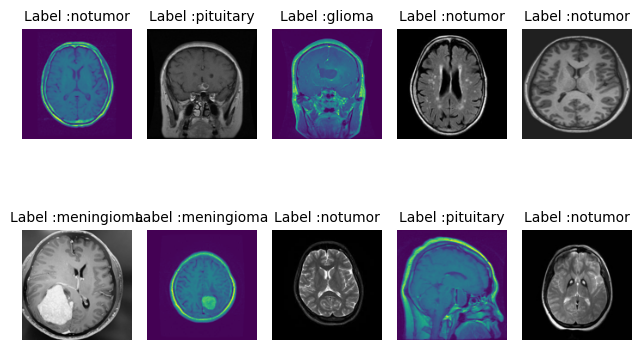

In [6]:
import random
import matplotlib.pyplot as plt

#select random indecies for 10 images
random_indecies = random.sample(range(len(train_paths)),10) #It extracts 10 random image id's

#create a figure to display images in 2 rows and 5 columns
fig, axes = plt.subplots(2,5)
axes = axes.ravel()

#loop through the random indecies and display images
for i, idx in enumerate(random_indecies):
  img_path = train_paths[idx] #Get the path of the image which inside the train path
  img = Image.open(img_path) #Reading the image
  img = img.resize((128,128))

  #Display images
  axes[i].imshow(img)
  axes[i].axis("off")
  axes[i].set_title(f"Label :{train_labels[idx]}",fontsize=10)

plt.tight_layout()
plt.show()



**Image Preprocessing**

In [9]:
#Image Augmentation Function
#This is data preprocessing, the work of this function is just to an image will come near him, he will click on that image, processing return us a numpy array
def augemnt_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image = np.array(image)/255.0
  return image

#Load images and apply augmentation
# Job of this function is to return an array will read the image in the form
def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = augemnt_image(img)
    images.append(img)
  return np.array(images)

#Encoder labels (Convert label names to integers)
#The work of this function is that whatever it has there are four levels, convert them into integers
def encode_label(labels):
  unique_labels = sorted(os.listdir(train_dr)) # Ensure consistent order
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded) # Return as NumPy array

#Data generator for batching
#This is the main function, the whole job is put the data into batches, in the batches it will provide the data so that it is an advantage that your model has speed, performance will increase
def datagen(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = encode_label(batch_labels)
      yield batch_images, batch_labels

Transfer learning is a technique in machine learning and deep learning where model is trained on one task that can be reused and adapted to solve a different problem but related tasks. Instead of training a model from scratch.

There are two types of transfer learning which one is NLP and other is computer vision.

In computer vision, we can use many models like VGG16, VGG19 apart from these RES-NET model which is image net, the dataset is alredy trained and you can also image classification or object detection using pre trained model for detection. we can use our new data but whatever is new task is to have new data it must be pre-trained model on similar data.

There are two advantages by using transfer learning, one is It saves lot of time and lot of memory also, no need to write code from scratch.
The second advantage is if you train models from scratch it may be the results of that model or if the performance is poor then we can pre trained, we use the model, layers and parameters  or whatever knowledge we have can be used in new task.

In [10]:
#Model Architecture
IMAGE_SIZE = 128 # Image Size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

#Freeze all layers of the VGG16 base model
for layer in base_model.layers:
  layer.trainable = False

#Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))) #Input layer
model.add(base_model) #Add VGG16 base model
model.add(Flatten()) #Flatten the output of base model
model.add(Dropout(0.3)) #Dropout layer for regularization
model.add(Dense(128, activation='relu')) #Dense layer wth Relu activation
model.add(Dropout(0.2)) #Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dr)), activation='softmax')) #output layer with softmax

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths)/batch_size) #Steps per epoch
epochs = 5

#Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs), epochs=epochs,steps_per_epoch=steps )

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2666s 9s/step - loss: 0.6744 - sparse_categorical_accuracy: 0.7236
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1225s 4s/step - loss: 0.2426 - sparse_categorical_accuracy: 0.9097
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1214s 4s/step - loss: 0.1838 - sparse_categorical_accuracy: 0.9290
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1221s 4s/step - loss: 0.1164 - sparse_categorical_accuracy: 0.9548
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1218s 4s/step - loss: 0.0795 - sparse_categorical_accuracy: 0.9714


**Train and Val Plots**

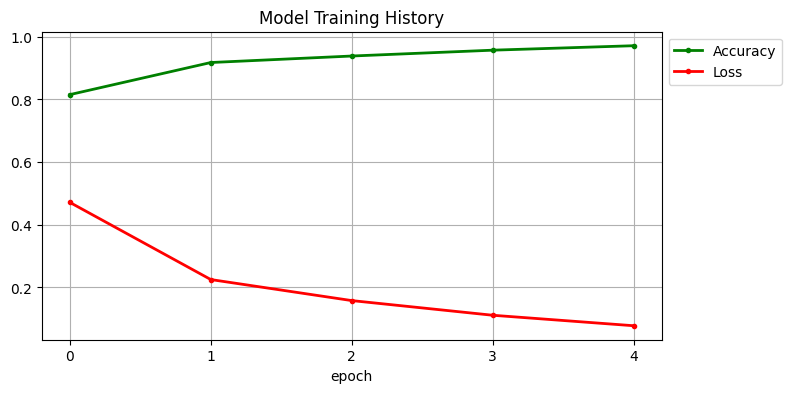

In [11]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**Model Classification Report**

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

#Prediction on test data
test_images = open_images(test_paths) #Load and augment test images
test_labels_encoded = encode_label(test_labels) #Encode the test labels

#Predict using the train model
test_predictions = model.predict(test_images)

#Classification report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 277s 7s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       300
           1       0.90      0.98      0.94       306
           2       1.00      1.00      1.00       405
           3       0.99      0.97      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



**Model Confusion Plot**

Confusion Matrix:
[[272  26   1   1]
 [  4 299   0   3]
 [  0   1 404   0]
 [  1   7   0 292]]


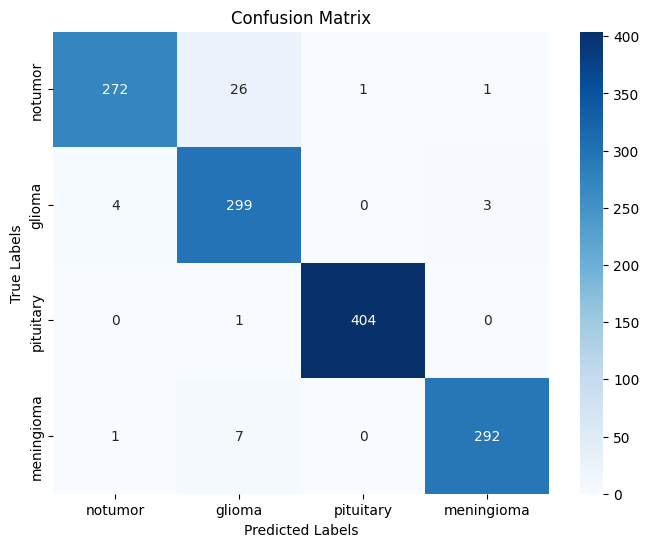

In [15]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

#Plot the confusion matrix
# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dr), yticklabels=os.listdir(train_dr))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**ROC Curve Plot**

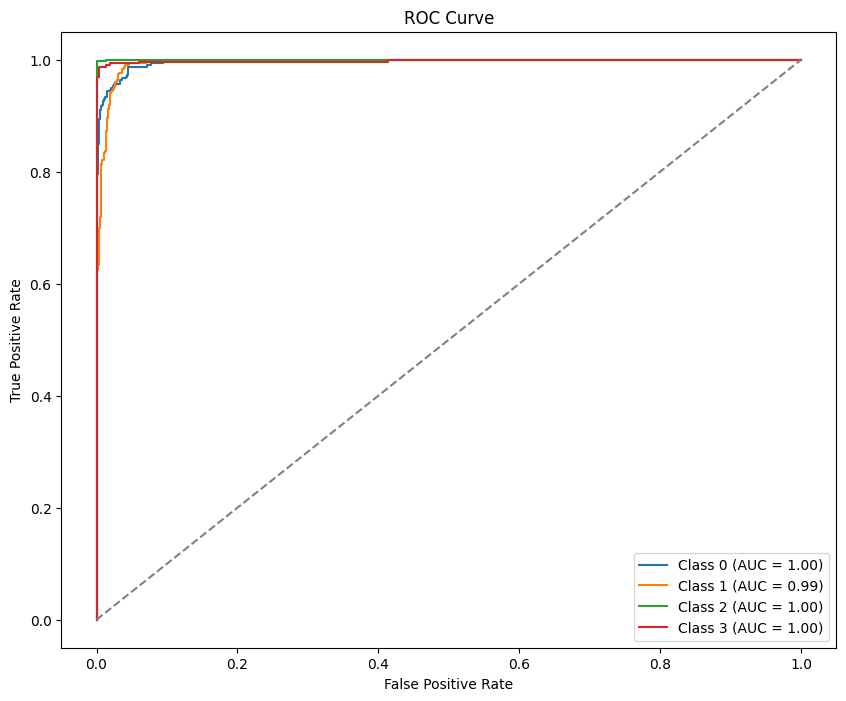

In [19]:
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dr))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dr))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dr))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

**Save & Load Model**

In [20]:
#Save the entire model
model.save('/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/model.h5')

In [21]:
# Save the entire model
model.save('model.h5')

In [22]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

**MRI Tumor Detection System**

In [25]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


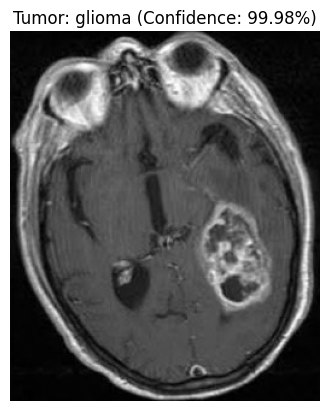

In [26]:
# Example usage
image_path = '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


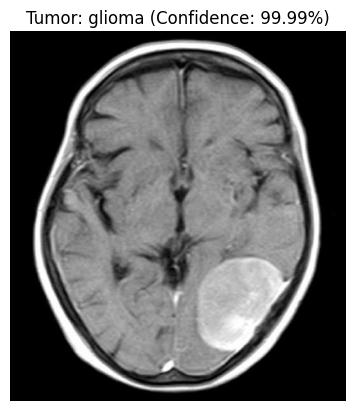

In [27]:
# Example usage
image_path = '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/meningioma/Te-meTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


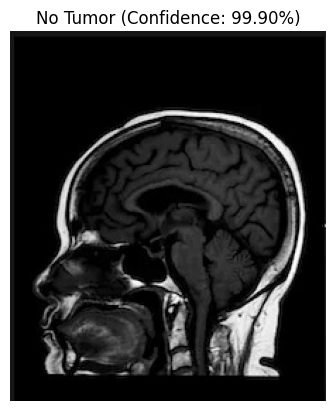

In [29]:
# Example usage
image_path = '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


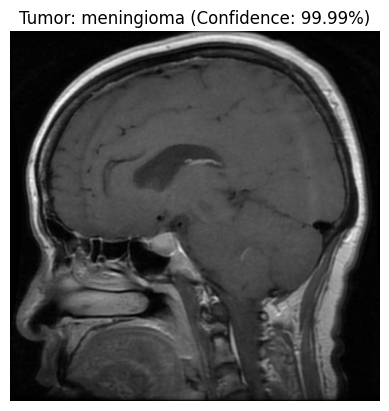

In [30]:
# Example usage
image_path = '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


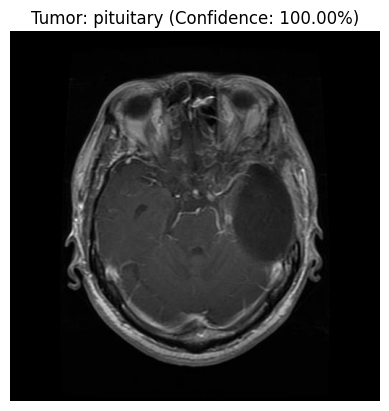

In [31]:
# Example usage
image_path = '/content/drive/MyDrive/Projects/Brain Tumor Detection Using Deep Learning/MRI Images/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)